# Set-Up

In [1]:
# Import required Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import load_model
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip "/content/gdrive/My Drive/Group 3244-2010-0014/Kaggle Data/petfinder-adoption-prediction.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train_sentiment/a8a1d4151.json  
  inflating: train_sentiment/a8a2aecc3.json  
  inflating: train_sentiment/a8a3c4f49.json  
  inflating: train_sentiment/a8a8f95f6.json  
  inflating: train_sentiment/a8b358af2.json  
  inflating: train_sentiment/a8b9d57b4.json  
  inflating: train_sentiment/a8ba4dfa1.json  
  inflating: train_sentiment/a8c19a325.json  
  inflating: train_sentiment/a8c336257.json  
  inflating: train_sentiment/a8c555240.json  
  inflating: train_sentiment/a8cdba660.json  
  inflating: train_sentiment/a8ce7d647.json  
  inflating: train_sentiment/a8cfb849e.json  
  inflating: train_sentiment/a8cfbf446.json  
  inflating: train_sentiment/a8d14470d.json  
  inflating: train_sentiment/a8d44452c.json  
  inflating: train_sentiment/a8d9108c4.json  
  inflating: train_sentiment/a8da358d1.json  
  inflating: train_sentiment/a8de0737e.json  
  inflating: train_sentiment/a8df693c0.json  
  inflating: train_sentiment/

# Prepare Dataset into Training, Validation and Testing Data

In [4]:
# Read Main CSV File
df = pd.read_csv("/content/train/train.csv")

# Remove Data without Image
df = df[df.PhotoAmt != 0]

# Re-index
df.index = list(range(len(df)))

# Add file extension
df["PetID"] = list(map(lambda x: x + "-1.jpg", df["PetID"]))

# Convert AdoptionSpeed column to Binary values
df["AdoptionSpeed"] = list(map(lambda x: "1" if x != 4 else "0", df["AdoptionSpeed"]))

# Split Dataset into Dogs and Cats separately
df_1 = df[df["Type"] == 1]
df_2 = df[df["Type"] == 2]

df_1.index = list(range(len(df_1)))
df_2.index = list(range(len(df_2)))

In [5]:
train_dir = "/content/train_images"
IMG_SIZE = 256
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
batch_size = 128
epochs = 50

In [6]:
train_image_generator = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest', validation_split=0.2)
test_image_generator = ImageDataGenerator(rescale=1./255)

In [7]:
# Split a part of data for Testing
df_1_train_amt = int((9/10) * len(df_1))
df_2_train_amt = int((9/10) * len(df_2))

print(df_1_train_amt, df_2_train_amt)

7144 6042


In [8]:
train_data_gen_1 = train_image_generator.flow_from_dataframe(df_1[:df_1_train_amt],
                                                       directory= train_dir,
                                                       x_col='PetID',
                                                       y_col="AdoptionSpeed",
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       subset = "training",
                                                       target_size=(IMG_SIZE,IMG_SIZE),
                                                       class_mode='binary')

validation_data_gen_1 = train_image_generator.flow_from_dataframe(df_1[:df_1_train_amt],
                                                       directory= train_dir,
                                                       x_col='PetID',
                                                       y_col="AdoptionSpeed",
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       subset = "validation",
                                                       target_size=(IMG_SIZE,IMG_SIZE),
                                                       class_mode='binary')

test_data_gen_1 = test_image_generator.flow_from_dataframe(df_1[df_1_train_amt:],
                                                       directory = train_dir,
                                                       x_col = 'PetID',
                                                       y_col = "AdoptionSpeed",
                                                       batch_size = batch_size,
                                                       shuffle = False,
                                                       target_size=(IMG_SIZE,IMG_SIZE),
                                                       class_mode = None)

Found 5716 validated image filenames belonging to 2 classes.
Found 1428 validated image filenames belonging to 2 classes.
Found 794 validated image filenames.


In [9]:
train_data_gen_2 = train_image_generator.flow_from_dataframe(df_2[:df_2_train_amt],
                                                       directory= train_dir,
                                                       x_col='PetID',
                                                       y_col="AdoptionSpeed",
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       subset = "training",
                                                       target_size=(IMG_SIZE,IMG_SIZE),
                                                       class_mode='binary')

validation_data_gen_2 = train_image_generator.flow_from_dataframe(df_2[:df_2_train_amt],
                                                       directory= train_dir,
                                                       x_col='PetID',
                                                       y_col="AdoptionSpeed",
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       subset = "validation",
                                                       target_size=(IMG_SIZE,IMG_SIZE),
                                                       class_mode='binary')

test_data_gen_2 = test_image_generator.flow_from_dataframe(df_2[df_2_train_amt:],
                                                       directory = train_dir,
                                                       x_col = 'PetID',
                                                       y_col = "AdoptionSpeed",
                                                       batch_size = batch_size,
                                                       shuffle = False,
                                                       target_size=(IMG_SIZE,IMG_SIZE),
                                                       class_mode = None)

Found 4834 validated image filenames belonging to 2 classes.
Found 1208 validated image filenames belonging to 2 classes.
Found 672 validated image filenames.


# Load Previously Trained Model

In [ ]:
#model = load_model(r"/content/gdrive/My Drive/Colab Notebooks/my_model_3.h5")

# Set-up Model

In [10]:
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False
base_model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
__________________________

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output')

In [12]:
model_dog = tf.keras.Sequential([base_model,
                                 global_average_layer,
                                 prediction_layer])

model_dog.compile(optimizer = SGD(lr=0.001, momentum=0.9),
                  loss ='binary_crossentropy',
                  metrics = ['accuracy'])

model_dog.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
output (Dense)               (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [13]:
model_cat = tf.keras.Sequential([base_model,
                                 global_average_layer,
                                 prediction_layer])

model_cat.compile(optimizer = SGD(lr=0.001, momentum=0.9),
                  loss ='binary_crossentropy',
                  metrics = ['accuracy'])

model_cat.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
output (Dense)               (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


# Train Model

In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
history = model_dog.fit(train_data_gen_1,
                    steps_per_epoch = train_data_gen_1.samples // batch_size,
                    validation_data = validation_data_gen_1, 
                    validation_steps = validation_data_gen_1.samples // batch_size,
                    epochs = epochs,
                    callbacks=[es]
                    )

Epoch 1/50
44/44 [==============================] - 126s 3s/step - loss: 0.6188 - accuracy: 0.6877 - val_loss: 0.6007 - val_accuracy: 0.7088
Epoch 2/50
44/44 [==============================] - 120s 3s/step - loss: 0.5943 - accuracy: 0.7096 - val_loss: 0.5916 - val_accuracy: 0.7109
Epoch 3/50
44/44 [==============================] - 116s 3s/step - loss: 0.5861 - accuracy: 0.7110 - val_loss: 0.5929 - val_accuracy: 0.7095
Epoch 4/50
44/44 [==============================] - 117s 3s/step - loss: 0.5784 - accuracy: 0.7105 - val_loss: 0.5824 - val_accuracy: 0.7102
Epoch 5/50
44/44 [==============================] - 117s 3s/step - loss: 0.5769 - accuracy: 0.7105 - val_loss: 0.5775 - val_accuracy: 0.7195
Epoch 6/50
44/44 [==============================] - 117s 3s/step - loss: 0.5701 - accuracy: 0.7167 - val_loss: 0.5798 - val_accuracy: 0.7088
Epoch 7/50
44/44 [==============================] - 118s 3s/step - loss: 0.5725 - accuracy: 0.7167 - val_loss: 0.5779 - val_accuracy: 0.7188
Epoch 8/50
44

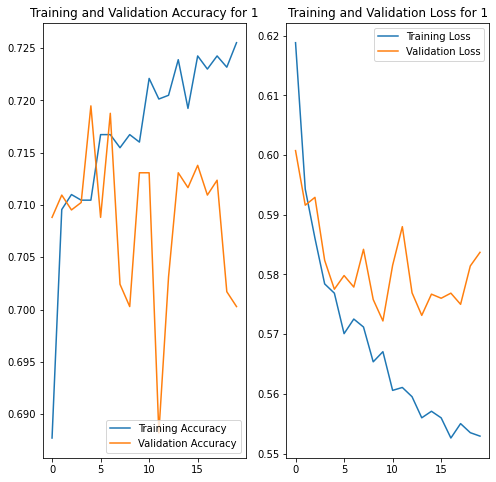

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(20) ### Change depending on number of epochs trained 

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy for 1')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for 1')
plt.show()

In [21]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
history2 = model_cat.fit(train_data_gen_2,
                    steps_per_epoch = train_data_gen_2.samples // batch_size,
                    validation_data = validation_data_gen_2, 
                    validation_steps = validation_data_gen_2.samples // batch_size,
                    epochs = epochs,
                    callbacks=[es]
                    )

Epoch 1/50
37/37 [==============================] - 105s 3s/step - loss: 0.5600 - accuracy: 0.7544 - val_loss: 0.6043 - val_accuracy: 0.7161
Epoch 2/50
37/37 [==============================] - 99s 3s/step - loss: 0.5504 - accuracy: 0.7546 - val_loss: 0.6012 - val_accuracy: 0.7161
Epoch 3/50
37/37 [==============================] - 100s 3s/step - loss: 0.5510 - accuracy: 0.7539 - val_loss: 0.5962 - val_accuracy: 0.7196
Epoch 4/50
37/37 [==============================] - 100s 3s/step - loss: 0.5429 - accuracy: 0.7565 - val_loss: 0.5955 - val_accuracy: 0.7231
Epoch 5/50
37/37 [==============================] - 100s 3s/step - loss: 0.5428 - accuracy: 0.7537 - val_loss: 0.5914 - val_accuracy: 0.7196
Epoch 6/50
37/37 [==============================] - 100s 3s/step - loss: 0.5381 - accuracy: 0.7567 - val_loss: 0.5866 - val_accuracy: 0.7222
Epoch 7/50
37/37 [==============================] - 99s 3s/step - loss: 0.5351 - accuracy: 0.7580 - val_loss: 0.5962 - val_accuracy: 0.7196
Epoch 8/50
37/3

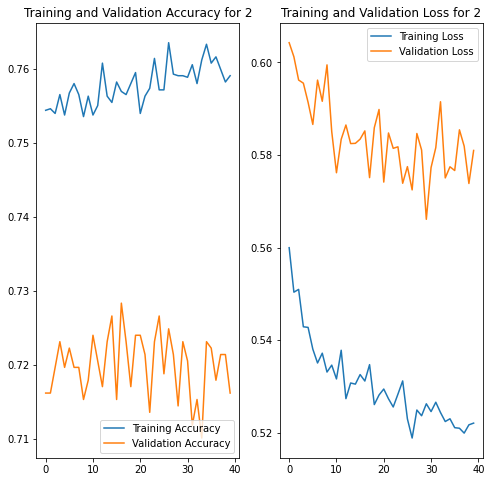

In [22]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs_range = range(40) ### Change depending on number of epochs trained 

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy for 2')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for 2')
plt.show()

# Save Model

In [ ]:
#model_dog.save('model_dog.h5')
#model_cat.save('model_cat.h5')

# Test Model

In [17]:
# Get Predicitions for Dog
dog_prob = model_dog.predict(test_data_gen_1, verbose=1)
dog_pred = list(map(lambda x: 1 if x[0] >= 0.5 else 0, dog_prob))

labels = (train_data_gen_1.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions_1 = [labels[k] for k in dog_pred]

7/7 [==============================] - 5s 679ms/step


In [20]:
result_1_df = pd.DataFrame({"Category 1 Predictions": predictions_1,
                          "Correct Category 1 Predictions": df_1[df_1_train_amt:]["AdoptionSpeed"]})

result_1_df["Category 1 Predictions"] = result_1_df["Category 1 Predictions"].astype(int)
result_1_df["Correct Category 1 Predictions"] = result_1_df["Correct Category 1 Predictions"].astype(int)

result_1_df["Correct"] = (result_1_df["Category 1 Predictions"] == result_1_df["Correct Category 1 Predictions"])

accuracy_1 = len(result_1_df[result_1_df["Correct"] == True])/len(result_1_df) *100
accuracy_1

72.544080604534

In [ ]:
result_1_df.to_csv("dog_test.csv")

In [23]:
# Get Predicitions for Cat
cat_prob = model_cat.predict(test_data_gen_2, verbose=1)
cat_pred = list(map(lambda x: 1 if x[0] >= 0.5 else 0, cat_prob))

labels = (train_data_gen_2.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions_2 = [labels[k] for k in cat_pred]

6/6 [==============================] - 4s 697ms/step


In [24]:
result_2_df = pd.DataFrame({"Category 2 Predictions": predictions_2,
                          "Correct Category 2 Predictions": df_2[df_2_train_amt:]["AdoptionSpeed"]})

result_2_df["Category 2 Predictions"] = result_2_df["Category 2 Predictions"].astype(int)
result_2_df["Correct Category 2 Predictions"] = result_2_df["Correct Category 2 Predictions"].astype(int)
result_2_df["Correct"] = (result_2_df["Category 2 Predictions"] == result_2_df["Correct Category 2 Predictions"])

accuracy_2 = len(result_2_df[result_2_df["Correct"] == True])/len(result_2_df) *100
accuracy_2

73.51190476190477

In [ ]:
result_2_df.to_csv("cat_test.csv")